In [25]:
import cv2
import numpy as np
from collections import Counter

# # # 25개의 색상 코드를 정의합니다.
# color_codes = ["#F4F0E5", "#D2C6B4", "#AE9C88", "#8E7861", "#6E5841", "#513A28", 
#                "#342113", "#180B05", "#010101", "#D7C384", "#B7A05D", "#9B7A4D", 
#                "#845B3B", "#664B2E", "#534228", "#3D2C18", "#B49C1E", "#A07429", 
#                "#8A4F2D", "#6F5232", "#4E5534", "#B26726", "#89392E", "#84432F", 
#                "#AC192A", "#AD1A2A", "#1D4F36", "#000000", "#D0CECF", 
#                "#840000", "#6D0000" # DarkRed
#                ]
color_codes = [
    '#E8E8E8', '#F5F5F5', '#FFF5ED', '#FEFEFE', '#FFFFFF',
    '#5A5856', '#6E605E', '#808080', '#A9A9A9', '#BEBEBE',
    '#000000', '#1C1C1C', '#362F00', '#2C2C2C',
    '#FF8C00', '#E4B206', '#FFA500', '#FAB000', '#FFB61F', '#FFD700',
    '#730606', '#B22222', '#DC143C', '#FF4500',
    '#228B22', '#747D00', '#798F11', '#6B8E23', '#858E1E',
    '#520561', '#7F2145', '#8F3C5B', '#EB3FA9',
    '#7B3F00', '#5C4033', '#6A482D', '#8B4513', '#805D47', "#9B7A4D", "#845B3B", "#664B2E", "#A07429", "#6F5232"
]


# color_codes = ["#AD1A2A", "#AC192A", # 빨강
#                 "#1D4F36", "#4E5534", # 초록
#                 "#F4F0E5", # 하양
#                 "#D2C6B4", "#AE9C88", "#8E7861", "#D7C384", "#B7A05D", "#B49C1E",  # 노란 계열 # 지방이 많이 포함된 음식
#                 "#000000", "#342113", "#180B05", "#010101", "#534228", "#3D2C18", # 검은색 계열
#                 "#9B7A4D", "#845B3B", "#664B2E", "#A07429", "#6F5232", # 갈색 계열
#                 "#8A4F2D"] 

# 위험 색상 목록을 정의합니다.
danger_colors = [
    "#F4F0E5", # 하양
    "#D2C6B4", "#AE9C88", "#8E7861", "#D7C384", "#B7A05D", "#B49C1E", # 노란 계열 
    "#AD1A2A", "#AC192A", # 선홍 빨강
    "#840000", "#6D0000", # Dark Red
    "#1D4F36", "#4E5534", # 초록
    "#000000", "#342113", "#180B05", "#010101", "#534228", "#3D2C18", # 검은색 계열
    "#D0CECF" # 회색
]



def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(color[0], color[1], color[2])

# OpenCV에서는 BGR을 사용하지만, 여기서는 RGB로 반환합니다.
color_codes_rgb = [hex_to_rgb(code) for code in color_codes]
danger_colors_rgb = [hex_to_rgb(code) for code in danger_colors]

In [26]:
print(color_codes_rgb)

[(232, 232, 232), (245, 245, 245), (255, 245, 237), (254, 254, 254), (255, 255, 255), (90, 88, 86), (110, 96, 94), (128, 128, 128), (169, 169, 169), (190, 190, 190), (0, 0, 0), (28, 28, 28), (54, 47, 0), (44, 44, 44), (255, 140, 0), (228, 178, 6), (255, 165, 0), (250, 176, 0), (255, 182, 31), (255, 215, 0), (115, 6, 6), (178, 34, 34), (220, 20, 60), (255, 69, 0), (34, 139, 34), (116, 125, 0), (121, 143, 17), (107, 142, 35), (133, 142, 30), (82, 5, 97), (127, 33, 69), (143, 60, 91), (235, 63, 169), (123, 63, 0), (92, 64, 51), (106, 72, 45), (139, 69, 19), (128, 93, 71)]


In [27]:
import matplotlib.pyplot as plt
def perceptual_color_quantization(image, color_palette):
    height, width, _ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 색변환
    quantized_image = image.copy()  # 입력 이미지를 복사하여 양자화된 이미지를 생성
    
    white_threshold = np.array([245, 245, 245])  # 하얀색으로 간주할 임계값 설정
    
    for y in range(height):
        for x in range(width):
            pixel_color = image[y, x]
            if np.all(pixel_color >= white_threshold):  # 하얀색 배경은 처리하지 않음
                continue
            closest_color = min(color_palette, key=lambda color: np.linalg.norm(pixel_color - color))
            quantized_image[y, x] = closest_color
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image at y={y}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(quantized_image)
    plt.title(f"Quantized Image at y={y}")
    plt.axis('off')
    plt.show()
    return quantized_image

In [28]:
def analyze_image_colors(quantized_image, danger_colors, threshold=15.0):
    # 하얀색으로 간주할 임계값 설정 (예: 약간의 여유를 둠)
    white_threshold = np.array([245, 245, 245])

    # 이미지를 2차원 배열로 평평하게 만듭니다.
    flat_image = quantized_image.reshape(-1, 3)
    
    # 하얀색이 아닌 픽셀만 선택
    non_white_pixels = [tuple(pixel) for pixel in flat_image if not np.all(pixel >= white_threshold)]
    
    # 각 색상의 출현 빈도를 계산합니다.
    color_counts = Counter(non_white_pixels)
    if not color_counts:
        # 비하얀 픽셀이 없을 경우 처리: 여기서는 None으로 반환하거나 기본값 설정
        return None, [], {}

    # 가장 많이 나타나는 색상(대표 색상)을 찾습니다.
    most_common_color = color_counts.most_common(1)[0][0]
    
    # 위험 색상 존재 여부 및 비율 확인
    detected_danger_colors = []
    danger_color_percentages = {}
    total_non_white_pixels = len(non_white_pixels)

    for color in danger_colors:
        color_tuple = tuple(color)
        if color_tuple in color_counts:
            # 위험 색상이 차지하는 비율 계산 (백분율)
            percentage = (color_counts[color_tuple] / total_non_white_pixels) * 100
            danger_color_percentages[color_tuple] = percentage
            
            # 임계값을 넘는 경우에만 위험 색상으로 추가
            if percentage >= threshold:
                detected_danger_colors.append(color_tuple)
    
    return most_common_color, detected_danger_colors, danger_color_percentages


In [29]:
def analyze_image(image, color_codes_rgb, danger_colors_rgb):
    # 이미지를 주어진 팔레트로 양자화
    quantized_image = perceptual_color_quantization(image, color_codes_rgb)
    
    # 함수 호출 예시
    threshold_value = 15.0  # 10% 이상의 색상만 위험 등급에 포함
    most_common_color, detected_danger_colors, danger_color_percentages = analyze_image_colors(quantized_image, danger_colors_rgb, threshold=threshold_value)

    print(f"대표 색상: {most_common_color}")
    print(f"감지된 위험 색상: {detected_danger_colors}")
    print(f"위험 색상 비율: {danger_color_percentages}")
    # RGB 값을 색상 코드로 변환
    most_common_color_hex = rgb_to_hex(most_common_color) if most_common_color else None
    detected_danger_colors_hex = [rgb_to_hex(color) for color in detected_danger_colors]
    
    # 결과를 반환합니다.
    return most_common_color, detected_danger_colors, most_common_color_hex, detected_danger_colors_hex


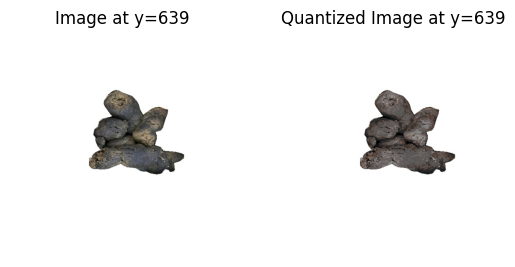

대표 색상: (90, 88, 86)
감지된 위험 색상: []
위험 색상 비율: {(0, 0, 0): 1.7149490792042636}
대표 색상: #5a5856
감지된 위험 색상: []


In [30]:
# 이미지를 불러옵니다.
# image = cv2.imread('/root/ai/dataset/classification_aug_apply/train/1/Type1_iter3_jpg.rf.120ab2fecf2da5c5636192b9a1f1e4af_aug_93.jpg')
# image = cv2.imread("/root/ai/dataset/classification_aug_apply/train/1/Type1_iter3_jpg.rf.120ab2fecf2da5c5636192b9a1f1e4af_aug_54.jpg")
image = cv2.imread("/root/ai/dataset/puppy_poo/dataset_cls_train_aug_apply/train/2/1671179453042_jpg.rf.a0cbcb5c212d818bdf3bce0ef6826ca5.jpg")

# 이미지에서 색상 분석을 수행합니다.
mc, dc, most_common_color, detected_danger_colors = analyze_image(image, color_codes_rgb, danger_colors_rgb)

print(f"대표 색상: {most_common_color}")
print(f"감지된 위험 색상: {detected_danger_colors}")

## 대표색

#6e5841
[]


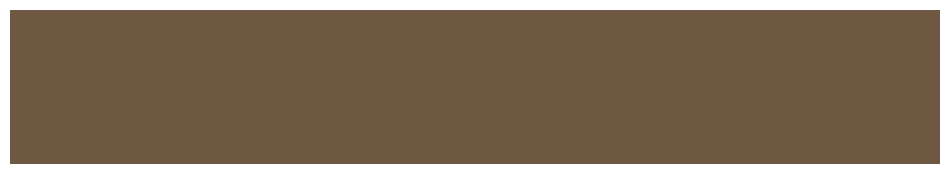

In [7]:
print(most_common_color)
print(detected_danger_colors)
# 대표 색상과 위험 색상을 하나의 리스트로 병합
all_colors = [most_common_color] + detected_danger_colors

# 각 색상을 plot으로 표시
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(all_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(all_colors))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()

[]
(110, 88, 65)


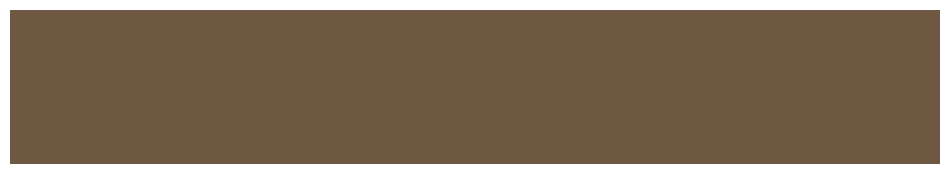

In [8]:
print(dc)
print(mc)
# 대표 색상과 위험 색상을 하나의 리스트로 병합
all_colors = [mc] + dc 

# 각 색상을 plot으로 표시
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(all_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array(color)/255))

ax.set_xlim(0, len(all_colors))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()

In [41]:
print(color_codes_rgb)
print(danger_colors_rgb)

[(244, 240, 229), (210, 198, 180), (174, 156, 136), (142, 120, 97), (110, 88, 65), (81, 58, 40), (52, 33, 19), (24, 11, 5), (1, 1, 1), (215, 195, 132), (183, 160, 93), (155, 122, 77), (132, 91, 59), (102, 75, 46), (83, 66, 40), (61, 44, 24), (180, 156, 30), (160, 116, 41), (138, 79, 45), (111, 82, 50), (78, 85, 52), (178, 103, 38), (137, 57, 46), (132, 67, 47), (172, 25, 42), (173, 26, 42), (29, 79, 54), (0, 0, 0), (208, 206, 207), (132, 0, 0), (109, 0, 0)]
[(244, 240, 229), (210, 198, 180), (174, 156, 136), (142, 120, 97), (215, 195, 132), (183, 160, 93), (180, 156, 30), (173, 26, 42), (172, 25, 42), (132, 0, 0), (109, 0, 0), (29, 79, 54), (78, 85, 52), (0, 0, 0), (52, 33, 19), (24, 11, 5), (1, 1, 1), (83, 66, 40), (61, 44, 24), (208, 206, 207)]


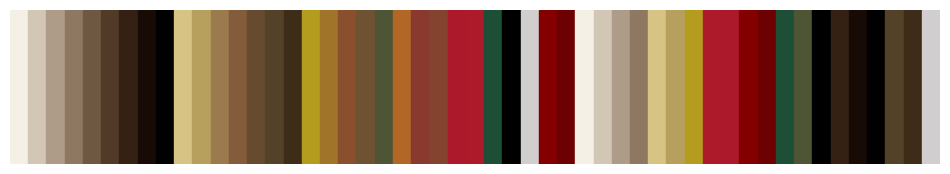

In [42]:
# 대표 색상과 위험 색상을 하나의 리스트로 병합
all_colors = color_codes_rgb + danger_colors_rgb

# 각 색상을 plot으로 표시
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(all_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array(color)/255))

ax.set_xlim(0, len(all_colors))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()